# LOADING THE NECESSARY PACKAGES

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
!pip install hdbscan
import hdbscan
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

     ------------------------------------ 602.4/602.4 kB 676.7 kB/s eta 0:00:00
     ------------------------------------ 989.5/989.5 kB 979.3 kB/s eta 0:00:00


In [3]:
#Loading the champo dataset
file_path = 'C:/Users/admin/Downloads/Champo Carpets V1.csv'
df = pd.read_csv(file_path)

# EDA 

In [4]:
print("First few rows of the dataset:")
print(df.head())

print("\nSummary of the dataset:")
df.info()

print("\nStatistical summaries of numerical features:")
print(df.describe())

First few rows of the dataset:
   OrderiD  Item_Id CustomerCode CountryName customer_country  QtyRequired  \
0        1        5          H-1         USA           H-1USA            6   
1        1       26          H-1         USA           H-1USA            6   
2        1       17          H-1         USA           H-1USA            7   
3        1      496          H-1         USA           H-1USA            7   
4        1       30          H-1         USA           H-1USA            5   

   TotalArea  Amount    ITEM_NAME            QualityName         DesignName  \
0     128.25   769.5  HAND TUFTED  TUFTED 30C HARD TWIST  OLD LONDON [3715]   
1     117.00   702.0  HAND TUFTED             TUFTED 60C      DUDLEY [9012]   
2      88.00   616.0  HAND TUFTED             TUFTED 60C    WEMBLY [CC-206]   
3      88.00   616.0  HAND TUFTED             TUFTED 60C    SYMPHONY [8900]   
4     117.00   585.0  HAND TUFTED             TUFTED 60C      DUDLEY [9012]   

     ColorName ShapeName 

Data Completeness: There are no missing values in the dataset, as all columns have 13,135 non-null entries.

# CUSTOMER DISTRIBUTION BY COUNTRY (6 Key Insights)

# 1. Customer Distribution by Country

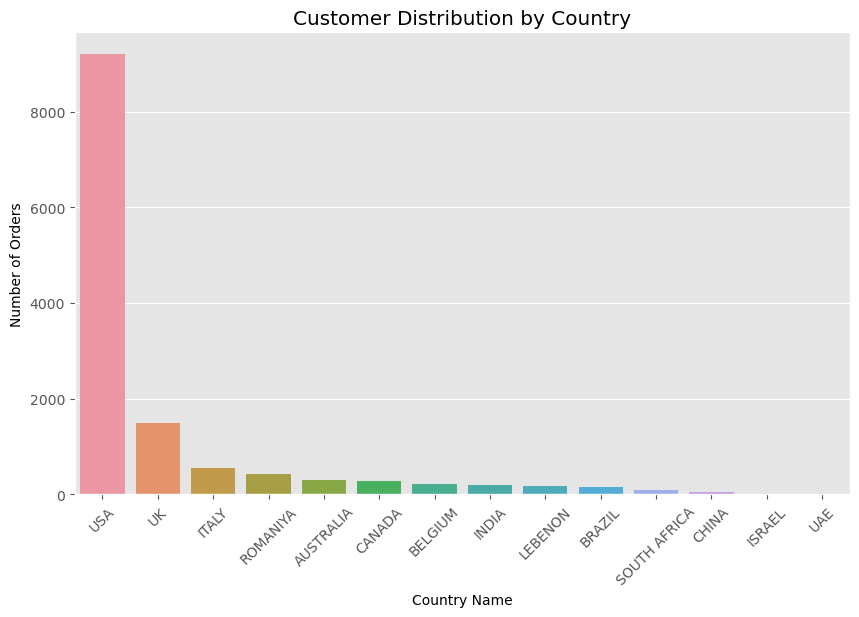

In [5]:
country_distribution = df['CountryName'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=country_distribution.index, y=country_distribution.values)
plt.xticks(rotation=45)
plt.xlabel('Country Name')
plt.ylabel('Number of Orders')
plt.title('Customer Distribution by Country')
plt.show()

# 2. Distribution By Total Area

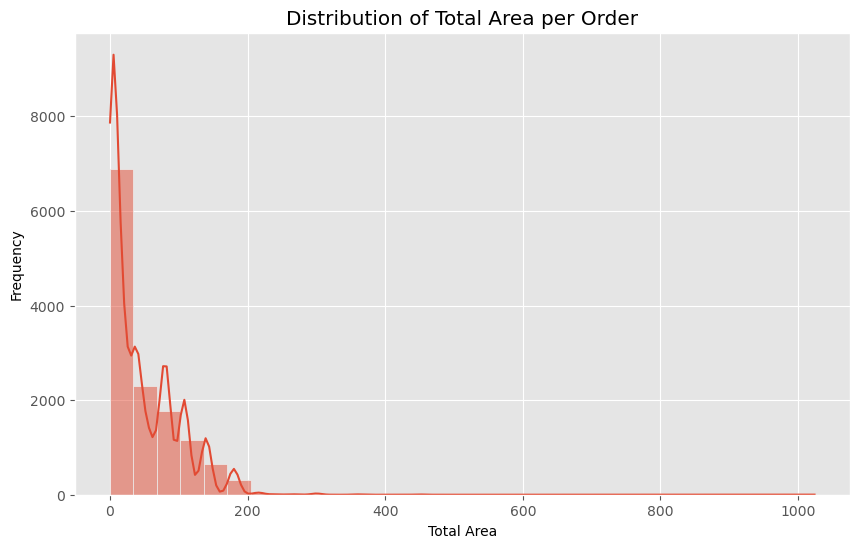

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalArea'], kde=True, bins=30)
plt.xlabel('Total Area')
plt.ylabel('Frequency')
plt.title('Distribution of Total Area per Order')
plt.show()

# 3.Distribution By Amount

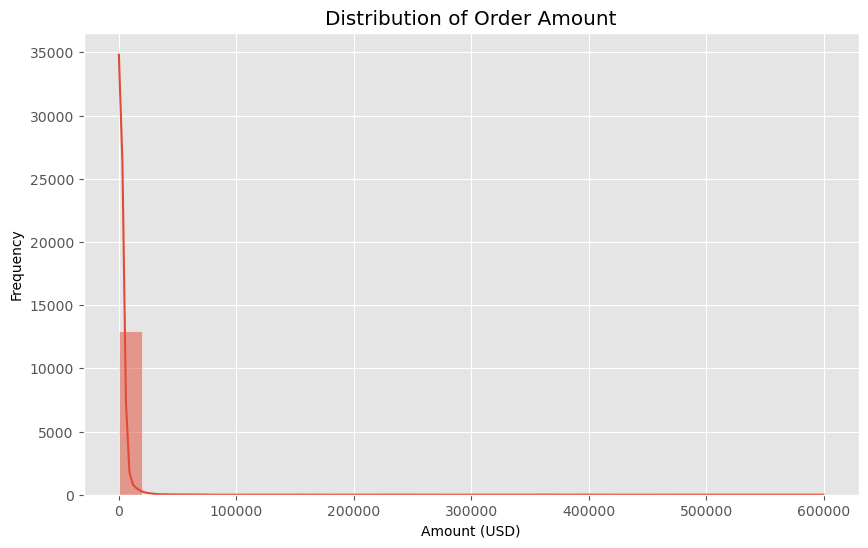

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], kde=True, bins=30)
plt.xlabel('Amount (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Order Amount')
plt.show()

# 4.Item Popularity (Top 10)

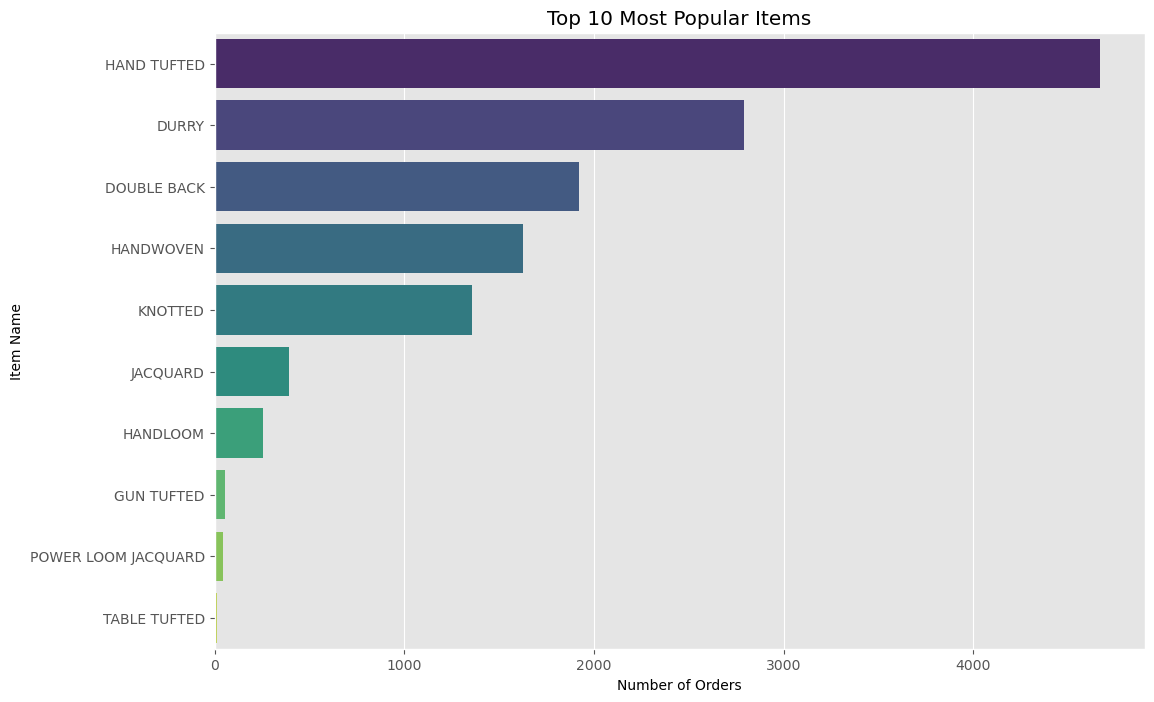

In [8]:
item_popularity = df['ITEM_NAME'].value_counts().head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=item_popularity.values, y=item_popularity.index, palette="viridis")
plt.xlabel('Number of Orders')
plt.ylabel('Item Name')
plt.title('Top 10 Most Popular Items')
plt.show()

# 5. Relationship Between Quantity Required and Total Area

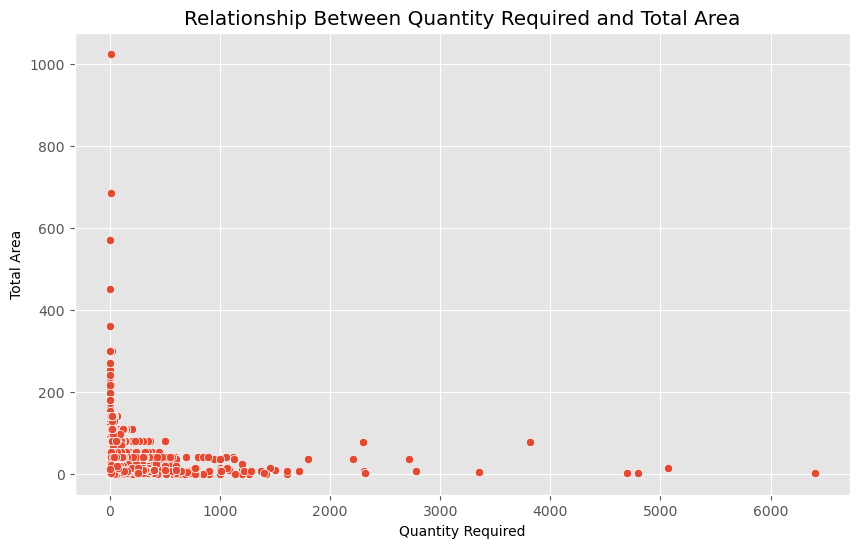

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='QtyRequired', y='TotalArea', data=df)
plt.xlabel('Quantity Required')
plt.ylabel('Total Area')
plt.title('Relationship Between Quantity Required and Total Area')
plt.show()

# 6. Revenue Analysis by Product Quality

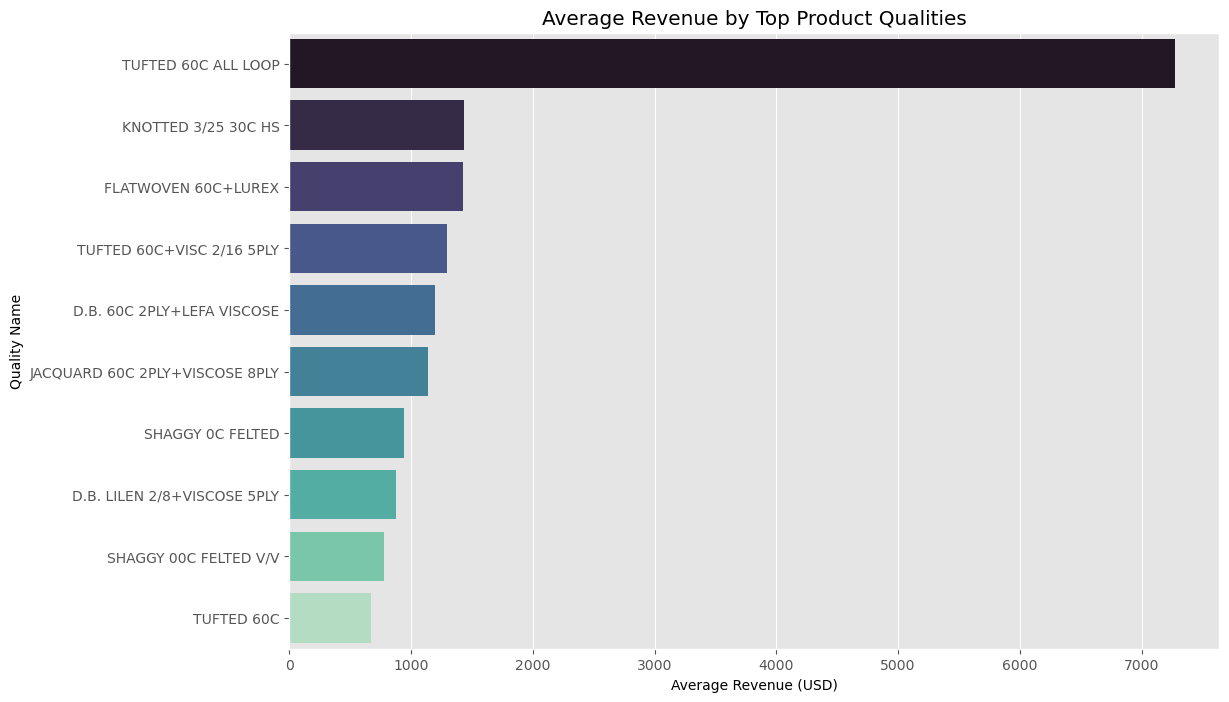

In [10]:
top_qualities = df['QualityName'].value_counts().head(10).index

# Filtering the dataset to include only the top quality categories
filtered_df = df[df['QualityName'].isin(top_qualities)]

# Grouping data by QualityName and calculating average revenue for each of the top quality categories
quality_revenue = filtered_df.groupby('QualityName')['Amount'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=quality_revenue.values, y=quality_revenue.index, palette="mako")
plt.xlabel('Average Revenue (USD)')
plt.ylabel('Quality Name')
plt.title('Average Revenue by Top Product Qualities')
plt.show()

# STAGE 1 (Customer Segmentation)

# Generating the two features below:

### 1.Frequency (number of orders)

In [11]:
frequency = df.groupby('CustomerCode')['OrderiD'].nunique()
frequency_df = pd.DataFrame({'Frequency': frequency})
print(frequency_df.head())

              Frequency
CustomerCode           
A-11                 11
A-6                   2
A-9                 210
B-2                   8
B-3                  11


### 2.Monetary Value from the customers

In [12]:
monetary_value = df.groupby('CustomerCode')['Amount'].sum()

# Adjusting display settings to show full numbers
pd.set_option('display.float_format', lambda x: '%.2f' % x)
monetary_value_df = pd.DataFrame({'MonetaryValue': monetary_value})
print(monetary_value_df.head())

              MonetaryValue
CustomerCode               
A-11              185404.10
A-6                 6247.46
A-9              1592079.79
B-2                14811.16
B-3                58626.86


### Combining the two features in a single dataframe

In [13]:
customer_features = pd.DataFrame({
    'Frequency': frequency,
    'MonetaryValue': monetary_value
})
print(customer_features.head())

              Frequency  MonetaryValue
CustomerCode                          
A-11                 11      185404.10
A-6                   2        6247.46
A-9                 210     1592079.79
B-2                   8       14811.16
B-3                  11       58626.86


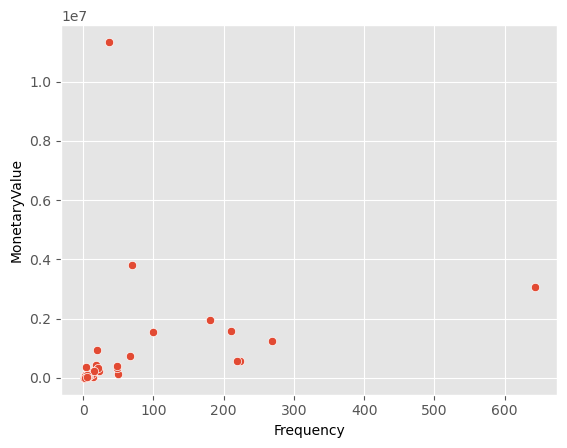

In [14]:
sns.scatterplot(data = customer_features,
              x = 'Frequency',
              y = 'MonetaryValue');

# Implementing Basic Clustering using Binning

In [15]:
max_frequency = customer_features['Frequency'].max()
max_monetary_value = customer_features['MonetaryValue'].max()

customer_features['f_bin'] = pd.cut(customer_features['Frequency'], bins=[0, 3, 6, 50, max_frequency], 
                                    labels=['Low', 'Medium', 'High', 'Others'], right=False)

customer_features['m_bin'] = pd.cut(customer_features['MonetaryValue'], bins=[0, 1000, 5000, 100000, max_monetary_value], 
                                    labels=['Low', 'Medium', 'High', 'Others'], right=False)
print(customer_features.head())


              Frequency  MonetaryValue   f_bin   m_bin
CustomerCode                                          
A-11                 11      185404.10    High  Others
A-6                   2        6247.46     Low    High
A-9                 210     1592079.79  Others  Others
B-2                   8       14811.16    High    High
B-3                  11       58626.86    High    High


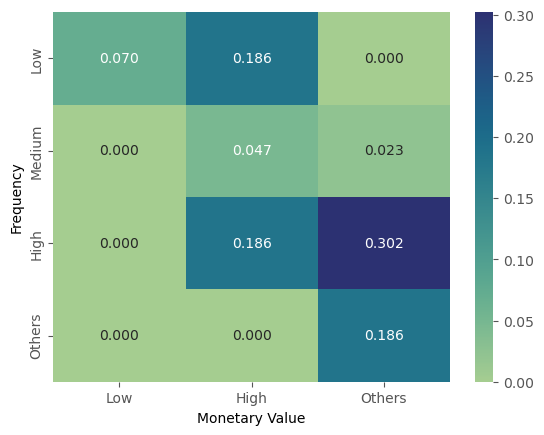

In [16]:
# Creating a crosstab for the FM segments
fm_segments = pd.crosstab(customer_features['f_bin'], customer_features['m_bin'], normalize='all')

sns.heatmap(fm_segments, annot=True, fmt="0.3f", cmap="crest")
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.show()


# STAGE 2

## 1. Scaling features

In [17]:
scaler = StandardScaler()
scaled_customer_features = scaler.fit_transform( customer_features[['Frequency',
                                                                   'MonetaryValue']] )
scaled_customer_features = pd.DataFrame(scaled_customer_features,
                                       columns = ['Frequency',
                                                 'MonetaryValue'])
print(scaled_customer_features.head())

   Frequency  MonetaryValue
0      -0.38          -0.29
1      -0.46          -0.39
2       1.40           0.50
3      -0.41          -0.38
4      -0.38          -0.36


## Applying Elbow Method to determine optimal number of Clusters

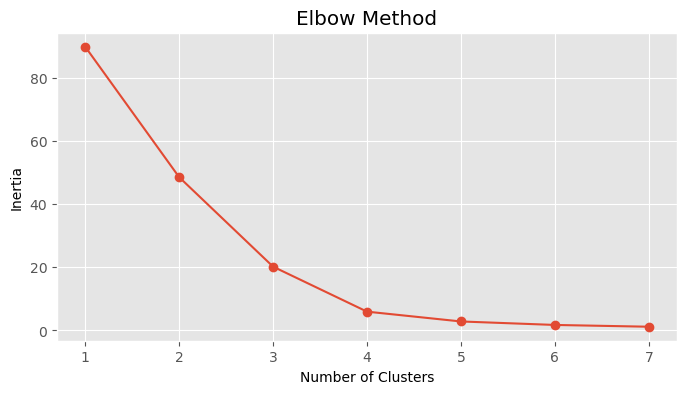

In [18]:
cluster_range = range(1, 8)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(n_clusters=num_clusters)
    clusters.fit(scaled_customer_features)
    cluster_errors.append(clusters.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(cluster_range, cluster_errors, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 1.Applying K-Means Clustering

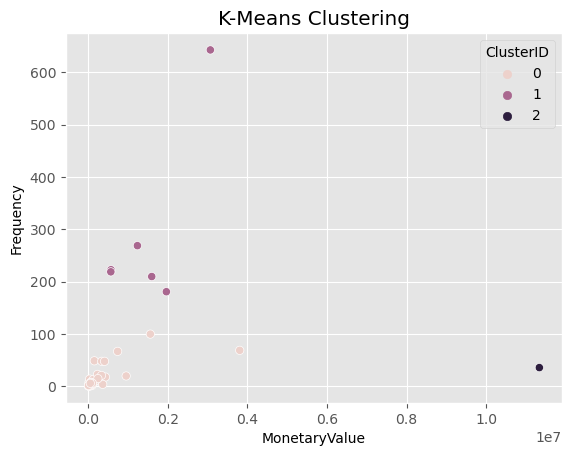

In [19]:
optimal_clusters = 3 
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['ClusterID'] = kmeans.fit_predict(scaled_customer_features)
customer_features['ClusterID'] = kmeans.labels_

sns.scatterplot(data=customer_features, x='MonetaryValue', y='Frequency', hue='ClusterID')
plt.title('K-Means Clustering')
plt.show()

In [20]:
cluster_0_data = customer_features[customer_features['ClusterID'] == 0]
print(cluster_0_data)

              Frequency  MonetaryValue   f_bin   m_bin  ClusterID
CustomerCode                                                     
A-11                 11      185404.10    High  Others          0
A-6                   2        6247.46     Low    High          0
B-2                   8       14811.16    High    High          0
B-3                  11       58626.86    High    High          0
B-4                   1       26242.50     Low    High          0
C-2                 100     1557123.00  Others  Others          0
C-3                   7       99062.35    High    High          0
CC                   49      147574.00    High  Others          0
CTS                   1       23800.00     Low    High          0
DR                   14       28648.12    High    High          0
E-2                   9      116778.30    High  Others          0
F-1                  13      116838.20    High  Others          0
F-6                   1       16800.00     Low    High          0
G-1       

In [21]:
cluster_1_data = customer_features[customer_features['ClusterID'] == 1]
print(cluster_1_data)

              Frequency  MonetaryValue   f_bin   m_bin  ClusterID
CustomerCode                                                     
A-9                 210     1592079.79  Others  Others          1
C-1                 223      567620.72  Others  Others          1
JL                  269     1231578.28  Others  Others          1
M-1                 181     1959794.03  Others  Others          1
P-5                 643     3066518.23     NaN  Others          1
T-2                 219      563098.85  Others  Others          1


In [22]:
cluster_2_data = customer_features[customer_features['ClusterID'] == 2]
print(cluster_2_data)

              Frequency  MonetaryValue f_bin m_bin  ClusterID
CustomerCode                                                 
TGT                  36    11341052.51  High   NaN          2


In [23]:
cluster_summary = customer_features.groupby('ClusterID').mean()
print(cluster_summary)

           Frequency  MonetaryValue
ClusterID                          
0              16.61      292044.87
1             290.83     1496781.65
2              36.00    11341052.51


# Evaluate The Quality of Clusters:
#### Silhouette Score

Average Silhouette Score for K-Means: 0.7745165106010069


NameError: name 'SilhouetteVisualizer' is not defined

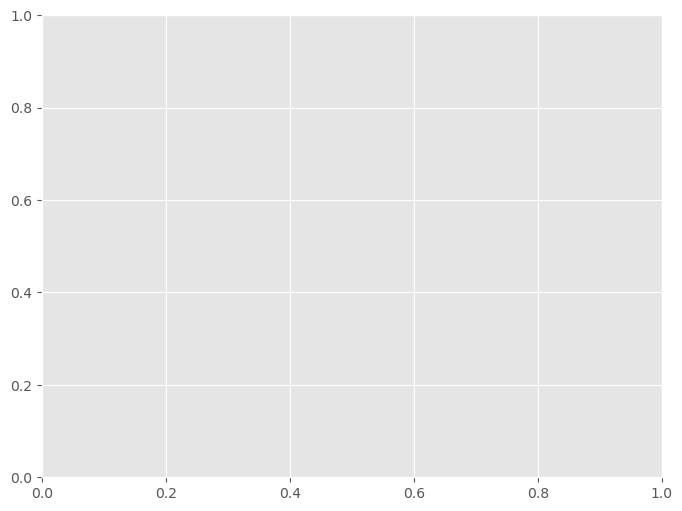

In [25]:
silhouette_avg = silhouette_score(scaled_customer_features, customer_features['ClusterID'])
print(f"Average Silhouette Score for K-Means: {silhouette_avg}")

fig, ax = plt.subplots(figsize=(8, 6))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
visualizer.fit(scaled_customer_features)
visualizer.show() 

## 2.Applying Agglomerative Clustering

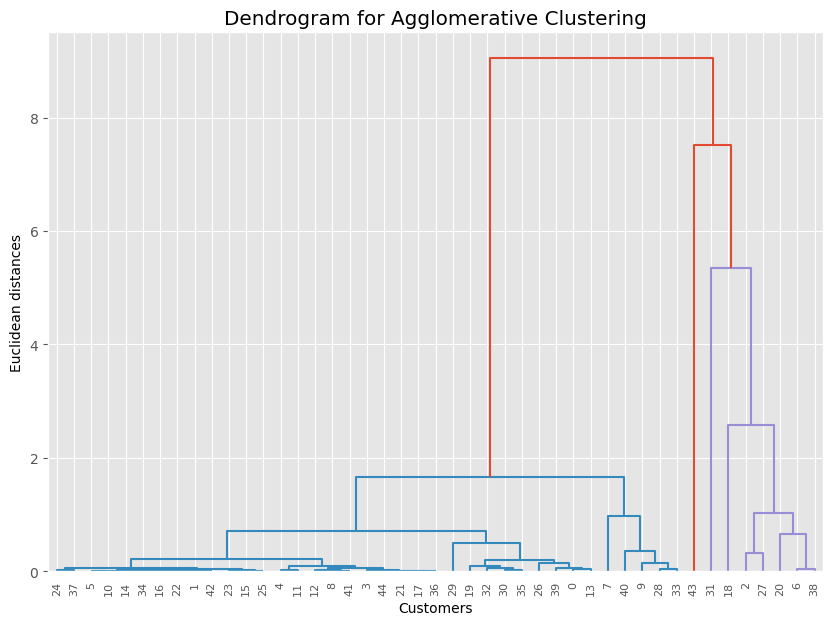

In [26]:
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(scaled_customer_features, method='ward'))
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()


In [27]:
n_clusters = 3
agglo_cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
customer_features['AggloClusterID'] = agglo_cluster.fit_predict(scaled_customer_features)


                Frequency  MonetaryValue  ClusterID
AggloClusterID                                     
0                  259.14     1826498.74       0.86
1                   15.19      197105.51       0.00
2                   36.00    11341052.51       2.00


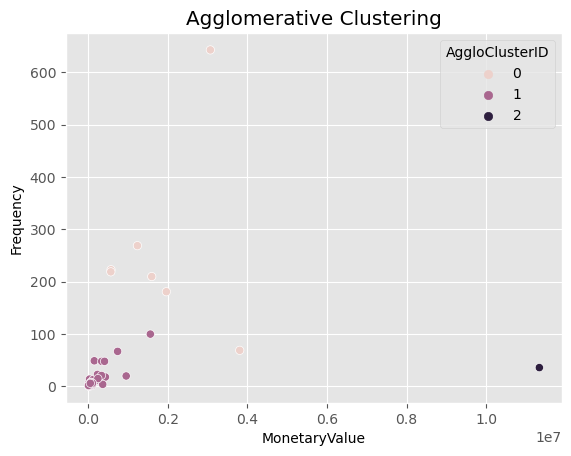

In [28]:
# Analyzing clusters
agglo_cluster_analysis = customer_features.groupby('AggloClusterID').mean()
print(agglo_cluster_analysis)

# Visualizing the clusters
sns.scatterplot(data=customer_features, x='MonetaryValue', y='Frequency', hue='AggloClusterID')
plt.title('Agglomerative Clustering')
plt.show()
 

In [29]:
silhouette_avg_agglo = silhouette_score(scaled_customer_features, customer_features['AggloClusterID'])
print(f"Average Silhouette Score for Agglomerative Clustering: {silhouette_avg_agglo}")

Average Silhouette Score for Agglomerative Clustering: 0.7718369528450285


# 3. Applying HDBSCAN Algorithm

In [30]:
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=4, gen_min_span_tree=True)
customer_features['HDBSCANCluster'] = hdbscan_cluster.fit_predict(scaled_customer_features)


                Frequency  MonetaryValue  ClusterID  AggloClusterID
HDBSCANCluster                                                     
-1                 254.25     4860987.58       1.00            0.50
 0                 208.25     1170648.35       1.00            0.00
 1                  15.19      197105.51       0.00            1.00


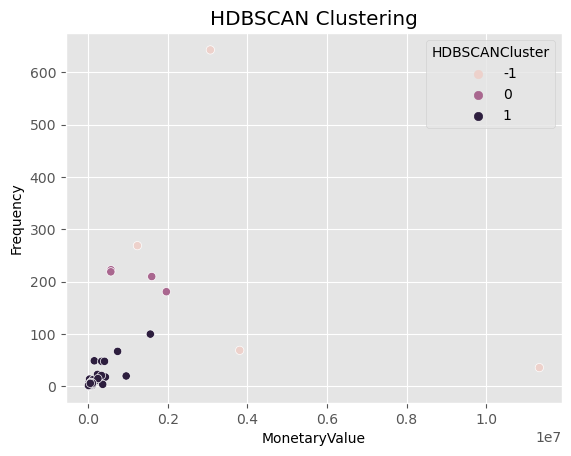

In [31]:
# Analyzing clusters
hdbscan_cluster_analysis = customer_features.groupby('HDBSCANCluster').mean()
print(hdbscan_cluster_analysis)


# Visualizing the clusters
sns.scatterplot(data=customer_features, x='MonetaryValue', y='Frequency', hue='HDBSCANCluster')
plt.title('HDBSCAN Clustering')
plt.show()


In [32]:
# Reseting the index of both DataFrames
scaled_customer_features.reset_index(drop=True, inplace=True)
customer_features.reset_index(drop=True, inplace=True)

# Creating the mask for non-noise data points
mask = customer_features['HDBSCANCluster'] != -1
filtered_data = scaled_customer_features[mask]
filtered_labels = customer_features[mask]['HDBSCANCluster']



### Evaluating the Quality of Clusters

In [33]:
# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(filtered_data, filtered_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(filtered_data, filtered_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


Calinski-Harabasz Index: 156.20256447927562
Davies-Bouldin Index: 0.2989932171254841


# Stage 3 
### Creating new features:

In [34]:
product_diversity = df.groupby('CustomerCode')['ITEM_NAME'].nunique().rename('ProductDiversityScore')
average_order_value = df.groupby('CustomerCode')['Amount'].mean().rename('AverageOrderValue')
Number_of_items = df.groupby('CustomerCode')['Item_Id'].nunique().rename('ItemDiversity')


customer_features = pd.DataFrame({
    'Frequency': frequency,
    'MonetaryValue': monetary_value,
    'ProductDiversityScore': product_diversity,
    'AverageOrderValue': average_order_value,
    'ItemDiversity': Number_of_items
})

print(customer_features.head())

              Frequency  MonetaryValue  ProductDiversityScore  \
CustomerCode                                                    
A-11                 11      185404.10                      2   
A-6                   2        6247.46                      2   
A-9                 210     1592079.79                      6   
B-2                   8       14811.16                      3   
B-3                  11       58626.86                      2   

              AverageOrderValue  ItemDiversity  
CustomerCode                                    
A-11                    4635.10             23  
A-6                      249.90             25  
A-9                     1357.27            504  
B-2                      315.13             44  
B-3                      814.26             72  


## SCALING

In [35]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

## Applying the three algorithms on the new customer features :
### 1. K-MEANS

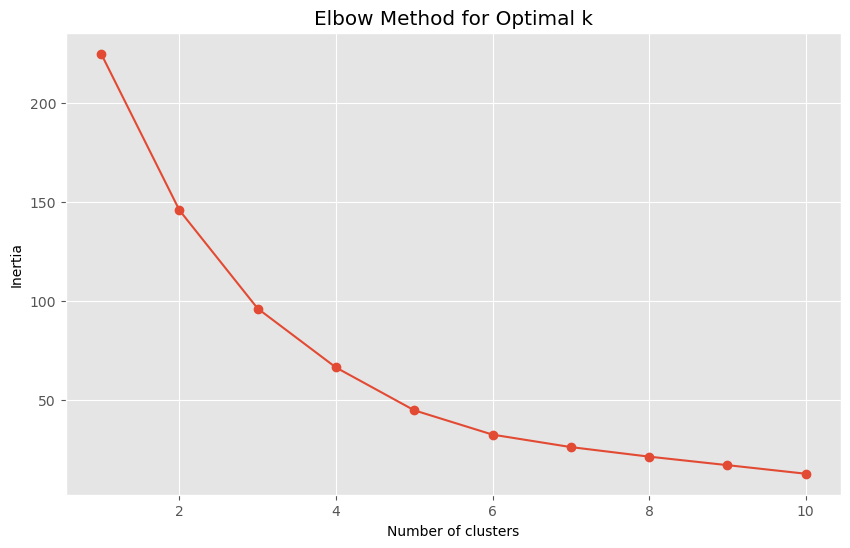

In [36]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [37]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)
kmeans_cluster_summary = customer_features.groupby('KMeans_Cluster').mean()
print(kmeans_cluster_summary)

                Frequency  MonetaryValue  ProductDiversityScore  \
KMeans_Cluster                                                    
0                   14.72      178516.28                   2.84   
1                   36.00    11341052.51                   1.00   
2                    2.00      139974.67                   1.00   
3                  211.00     1549550.02                   6.67   

                AverageOrderValue  ItemDiversity  
KMeans_Cluster                                    
0                         1755.60          69.47  
1                        18622.42          74.00  
2                        21517.33           2.67  
3                         1917.91         408.56  


    PC1   PC2  KMeans_Cluster
0 -1.03 -0.05               0
1 -0.93 -0.65               0
2  2.82  0.20               3
3 -0.59 -0.69               0
4 -0.74 -0.54               0


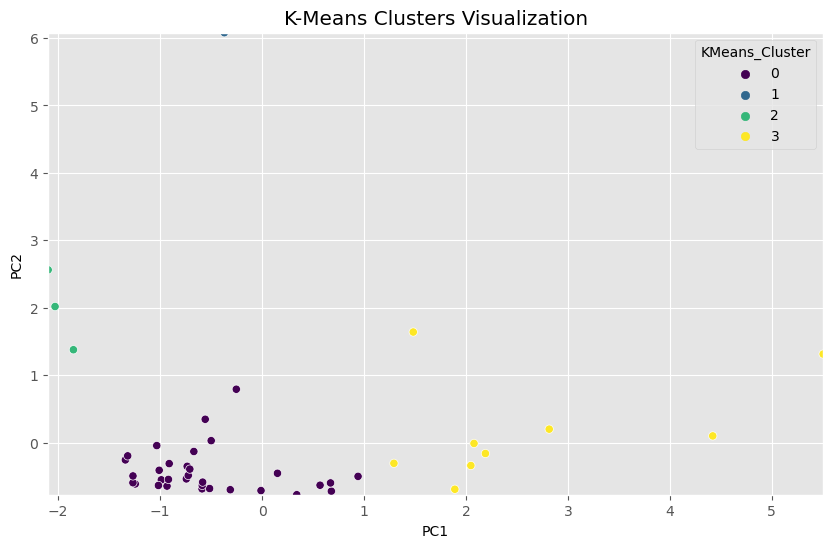

In [38]:
from sklearn.decomposition import PCA

# Reducing the data to two dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)

# Creating a DataFrame for the reduced data
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['KMeans_Cluster'] = customer_features['KMeans_Cluster'].values
print(reduced_df.head())


plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='KMeans_Cluster', palette='viridis')
plt.xlim(reduced_df['PC1'].min(), reduced_df['PC1'].max())  # Adjust x-axis limits
plt.ylim(reduced_df['PC2'].min(), reduced_df['PC2'].max())  # Adjust y-axis limits
plt.title('K-Means Clusters Visualization')
plt.show()

## 2. Agglomerative Clustering

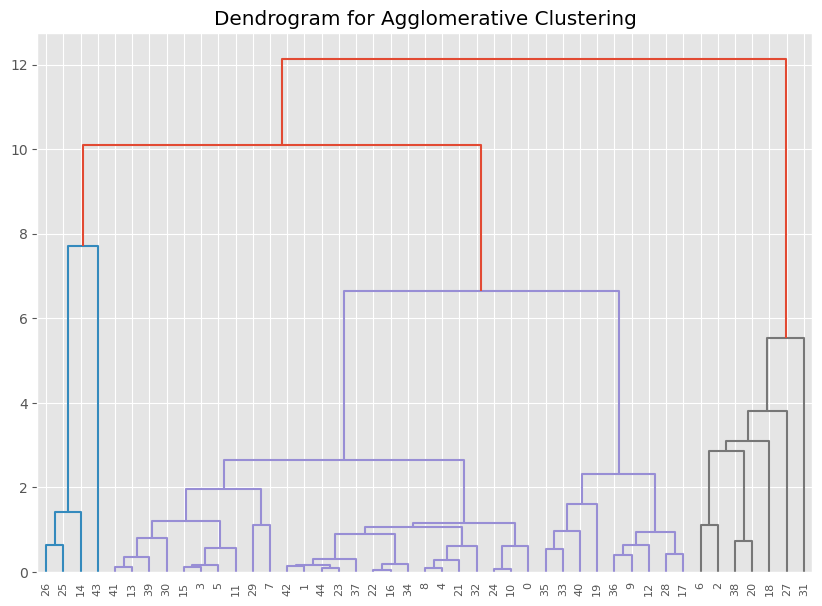

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(scaled_features, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Agglomerative Clustering')
plt.show()

In [40]:
agg_cluster = AgglomerativeClustering(n_clusters=5)
customer_features['Agglo_Cluster'] = agg_cluster.fit_predict(scaled_features)

agglo_cluster_summary = customer_features.groupby('Agglo_Cluster').mean()
print(agglo_cluster_summary)

               Frequency  MonetaryValue  ProductDiversityScore  \
Agglo_Cluster                                                    
0                 259.14     1826498.74                   6.57   
1                  11.28      170359.08                   2.20   
2                   2.00      139974.67                   1.00   
3                  36.00    11341052.51                   1.00   
4                  30.44      290444.75                   5.56   

               AverageOrderValue  ItemDiversity  KMeans_Cluster  
Agglo_Cluster                                                    
0                        2075.31         430.29            3.00  
1                        1988.50          40.80            0.00  
2                       21517.33           2.67            2.00  
3                       18622.42          74.00            1.00  
4                        1022.32         207.56            0.67  


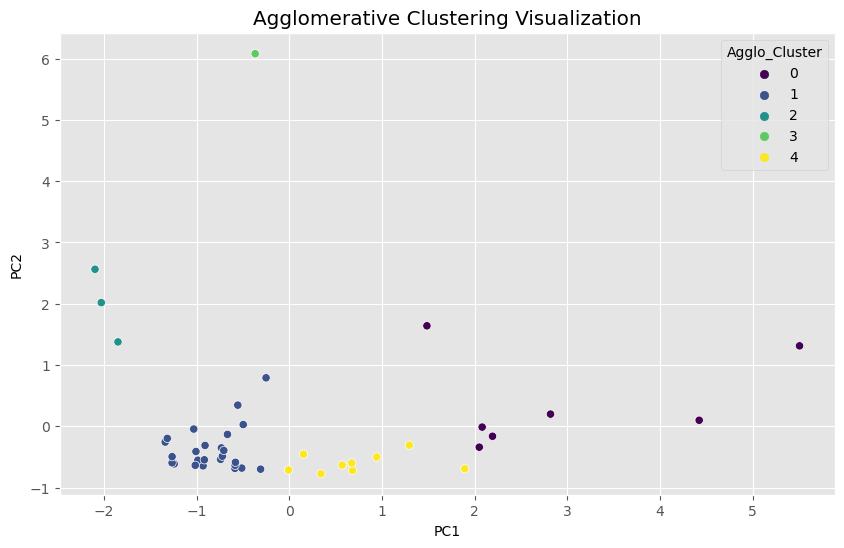

In [41]:
# Adding Agglomerative Clustering labels to the reduced DataFrame
reduced_df['Agglo_Cluster'] = customer_features['Agglo_Cluster'].values

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=reduced_df, x='PC1', y='PC2', hue='Agglo_Cluster', palette='viridis')
plt.title('Agglomerative Clustering Visualization')
plt.show()



# 3. HDBSCAN

In [42]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(scaled_features)
customer_features['Cluster'] = cluster_labels
customer_features.head()

,Frequency,MonetaryValue,ProductDiversityScore,AverageOrderValue,ItemDiversity,KMeans_Cluster,Agglo_Cluster,Cluster
CustomerCode,,,,,,,,
A-11,11,185404.10,2,4635.10,23,0,1,-1
A-6,2,6247.46,2,249.90,25,0,1,-1
A-9,210,1592079.79,6,1357.27,504,3,0,-1
B-2,8,14811.16,3,315.13,44,0,1,-1
B-3,11,58626.86,2,814.26,72,0,1,-1
